# IMAGINE tutorial 3 -- using hammurabi X 

### Here we show how to use hammurabiX with built-in field models.

This tutorial describes the interface to hammurabi X that will be used in IMAGINE.

In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import healpy as hp

from imagine import Measurements
from imagine import Hammurabi
from imagine import BregLSA
from imagine import CREAna
from imagine import TEregYMW16

The IMAGINE simulator that uses hammurabiX is the `Hammurabi` class, which in turn wraps hammurabiX's own python wrapper `hampyx`.  It is convenient not using hampyx directly, considering future updates in hammurabi X.  

Note that `hampyx` requires an XML parameter file input.  

### Generate a simulated dataset with hammurabiX

The initialization of the simulator includes defining which datasets are to be simulated.  It then prints its setup, showing that we have defined three observables:  

In [2]:
## Create some empty measuremnt arrays
arr32 = np.zeros((1, 12*32**2))
arr16 = np.zeros((1, 12*16**2))
arr8 = np.zeros((1, 12*8**2))
measuredict = Measurements()
## Fill the measurements object with these arrays and tell
##  it what sorts of data they are.  
##
## First, a synchrotron total intensity dataset at 23 GHz at Nside=32
measuredict.append(('sync', '23', '32', 'I'), arr32)  
## Then a Faraday depth dataset of Nside=16
measuredict.append(('fd', 'nan', '16', 'nan'), arr16)
## And a Faraday dispersion measure dataset at Nside=8.
measuredict.append(('dm', 'nan', '8', 'nan'), arr8)
## It needs to k now where the base XML template is.  You may want to 
##  store different sets of hammuarbi parameters in different XML files.
xmlpath = './template.xml'
simer = Hammurabi(measurements=measuredict,xml_path=xmlpath)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}


In addition to the types of data to simulate, the simulator also needs to be told what field models to use:

In [3]:
## ensemble size
ensemble_size = 2

## Set up the BregWMAP field with the parameters you want:
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregWMAP(paramlist, ensemble_size)

## Set up the analytic CR model CREAna 
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.6, 'z0': 1.2,
             'E0': 20.5,
             'j0': 0.03}
cre_ana = CREAna(paramlist, ensemble_size)


##  The free electron model based on YMW16, ie. FEregYMW16 
paramlist = dict()
fereg_ymw16 = FEregYMW16(paramlist, ensemble_size)

## Push fields to the simulator object initialized above:
simer.register_fields([breg_wmap, cre_ana, fereg_ymw16])

# Check the initialization of the simulator object:
simer._ham.print_par(['magneticfield', 'regular'])
simer._ham.print_par(['magneticfield', 'regular', 'wmap'])
simer._ham.print_par(['cre'])
simer._ham.print_par(['cre', 'analytic'])
simer._ham.print_par(['freeelectron', 'regular'])

regular {'cue': '1', 'type': 'lsa'}
|-->  lsa {}
|-->  jaffe {}
|-->  unif {}
cre {'cue': '1', 'type': 'analytic'}
|-->  analytic {}
|-->  unif {}
analytic {}
|-->  alpha {'value': '3.0'}
|-->  beta {'value': '0.0'}
|-->  theta {'value': '0.0'}
|-->  r0 {'value': '5.0'}
|-->  z0 {'value': '1.0'}
|-->  E0 {'value': '20.6'}
|-->  j0 {'value': '0.0217'}
regular {'cue': '1', 'type': 'ymw16'}
|-->  ymw16 {}
|-->  unif {}


Without running the IMAGINE pipeline itself, we illustrate how hammurabiX is invoked internally by the pipeline to generate one set of observables:

In [4]:
maps = simer([breg_wmap, cre_ana, fereg_ymw16])

`Simulator` by convention returns a `Simulations` object, which collect all required maps.  They are in an internal NIFTy-compatible format, so we want to get them back as arrays we can visualize with healpy.  The `to_global_data()`method does this, and note that what it gets back is a **set** of two of each type of observable, since we specified `ensemble_size=2` above.  But since we have not yet added a random component, they are both the same:  

dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])
(2, 12288) (2, 768) (2, 3072)


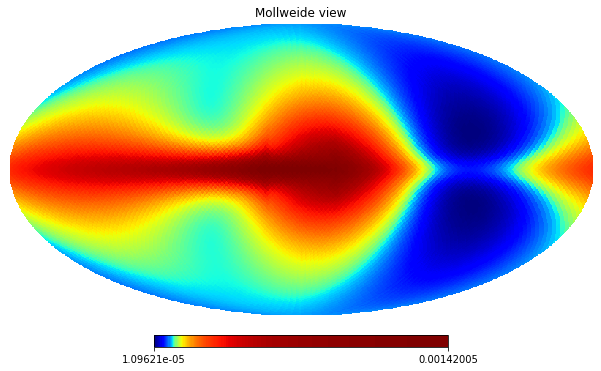

In [5]:
print (maps.keys())

sync_i_raw = maps[('sync','23','32','I')].to_global_data()
dm_raw = maps[('dm', 'nan', '8', 'nan')].to_global_data()
fd_raw = maps[('fd', 'nan', '16', 'nan')].to_global_data()

print (sync_i_raw.shape, dm_raw.shape, fd_raw.shape)

hp.mollview(sync_i_raw[0], norm='hist', cmap='jet')

### Add a random magnetic field

We add a random GMF component described by the ES model.  This model starts with a random number generator to simulate a Gaussian random field on a cartesian grid and ensures that it is divergence free.  The grid is defined in hammurabiX XML parameter file.  

In [6]:
## Modify the random field grid for limiting the notebook's memory consumption.
simer._ham.mod_par(['grid', 'box_brnd', 'nx'], {'value': '100'})
simer._ham.mod_par(['grid', 'box_brnd', 'ny'], {'value': '100'})
simer._ham.mod_par(['grid', 'box_brnd', 'nz'], {'value': '20'})

In [7]:
from imagine.fields.brnd_es.hamx_field import BrndES

paramlist = {'rms': 6., 'k0': 0.5, 'a0': 1.7, 'rho': 0.5, 'r0': 8., 'z0': 1.}
brnd_es = BrndES(paramlist, ensemble_size)

Now use the simulator to generate the maps from these field components and visualize:

In [8]:
maps = simer([breg_wmap, brnd_es, cre_ana, fereg_ymw16])

In [9]:
print (maps.keys())

sync_i_raw = maps[('sync','23','32','I')].to_global_data()
dm_raw = maps[('dm', 'nan', '8', 'nan')].to_global_data()
fd_raw = maps[('fd', 'nan', '16', 'nan')].to_global_data()

print (sync_i_raw.shape, dm_raw.shape, fd_raw.shape)

dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])
(2, 12288) (2, 768) (2, 3072)


In [10]:
maps[('fd', 'nan', '16', 'nan')]._data, maps[('fd', 'nan', '16', 'nan')].data
maps[('fd', 'nan', '16', 'nan')].dtype

'simulated'

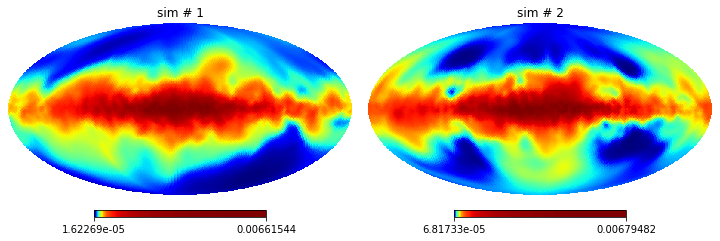

In [11]:
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(sync_i_raw[0], norm='hist', cmap='jet',sub=(1,2,1),title="sim # 1")
hp.mollview(sync_i_raw[1], norm='hist', cmap='jet',sub=(1,2,2),title="sim # 2")

### This ends tutorial 3. Continue to tutorials 4-5:
* [Tutorial 4](tutorial_four.ipynb):  Data masking
* [Tutorial 5](tutorial_five.ipynb):  An almost realistic pipeline run

Or see more examples in the *imagine/examples* directory